# SARIMAX

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tqdm.auto import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)

In [2]:
# one-step sarima forecast
def sarima_forecast(data, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(
        data,
        order=order,
        seasonal_order=sorder,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    # fit model
    model_fit = model.fit(disp=False)
    return model_fit

In [4]:
# create a set of sarima configs to try
def sarima_configs():
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = [0, 6, 12]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [5]:
def grid_search(train, test, configs):
    result = {}
    for cfg in tqdm(configs):
        try:
            model = sarima_forecast(
                data=train.tavg,
                config=cfg
            )
            preds = model.predict(start=len(train), end=len(train)+len(test)-1)
            result[f'{cfg}'] = mean_squared_error(
                test.tavg.to_numpy(),
                preds.to_numpy(),
                squared=False
            )
        except Exception as e:
            continue
    return dict(sorted(result.items(), key=lambda item: item[1]))

## Avarage Temperature

<b>Read Data</b>

In [13]:
train = pd.read_csv('data/tavg/train_1d.csv', index_col = ['date'], parse_dates = ['date'], dayfirst = True)
train = train.asfreq('d')
test = pd.read_csv('data/tavg/test_1d.csv', index_col = ['date'], parse_dates = ['date'], dayfirst = True)
test = test.asfreq('d')
data = pd.read_csv('data/tavg/full_1d.csv', index_col = ['date'], parse_dates = ['date'], dayfirst = True)
data = data.asfreq('d')

<b>Model Selection</b>

In [7]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [8]:
configs = sarima_configs()
scores = grid_search(train, test, configs)

  0%|          | 0/3888 [00:00<?, ?it/s]

In [12]:
import json

with open('tavg_params.json', 'w') as fp:
    json.dump(scores, fp)

In [19]:
min(scores, key=scores.get), scores[min(scores, key=scores.get)]

("[(0, 0, 1), (2, 0, 2, 12), 'c']", 4.145201012777856)

<b>Model</b>

In [32]:
model = sarima_forecast(data=train.tavg, config=[(0, 0, 1), (2, 0, 2, 12), 'c'])

Train Forecast

In [33]:
preds = model.predict(start=0, end=len(train))

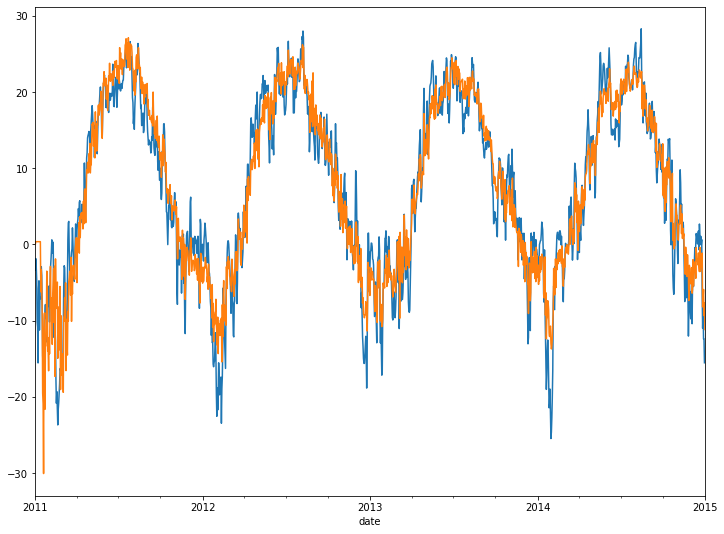

In [35]:
train.tavg.plot();
preds.plot();

Test Forecast

In [36]:
preds = model.predict(start=len(train), end=len(train)+len(test)-1)

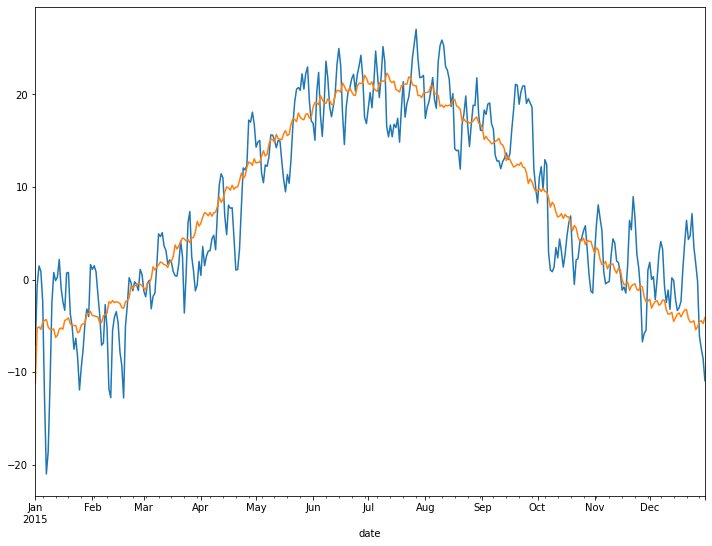

In [38]:
test.tavg.plot();
preds.plot();